# Шавель 853501 Лабораторная работа № 3

Вариант 25. Имеется одноканальная СМО с очередью, ограниченной числом мест R = 2. На вход СМО поступает простейший по ток заявок с интенсивностью X. Время обслуживания распределено по обобщенному закону Эрланга с параметрами k, X2. Найти вероятности состояний СМО и характеристики эффективности СМО.

По сути, единственным отличием в реализации относительно прошлой лабораторной работы является замена закона распределения для времени обслуживания на закон Эрланга и более сложным подсчетом теоретических вероятностей состояний. Для подсчета теоретических вероятностей добавим псевдосостояния системы. Так как поток Эрланга c первым параметром k является по сути обобщенным потоком Пуассона, в котором мы ждем происхождения не первого, а k-го события, то можно добавить промежуточные состояния, в которых это событие произошло 1, 2, ..., k - 1 раз. Таким образом, можно будет легко посчитать теоретические вероятности, просто приравняв входящий и исходящий потоки в каждом состоянии. Далее нужно только поставить каждому псевдосостоянию в соответсвие реальное состояние, и просуммировать вероятности для каждого реального состояния.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum
import heapq
import math
from collections import deque
from IPython.display import display, HTML

def sample(intensity):
    return np.random.exponential(1 / intensity)


def sample_erlang(shape, intensity):
    return np.random.gamma(shape, 1 / intensity)


class Action(Enum):
    REQUEST = 1
    SERVICE = 2
    

class Simulator:
    
    
    def __init__(self, rq_intensity, service_shape, service_intensity):
        self.channels_cnt = 1
        self.queue_size = 2
        self.rq_intensity = rq_intensity
        self.service_shape = service_shape
        self.service_intensity = service_intensity
    
    
    def theoretical_probs(self):
        state_probs = np.zeros(self.channels_cnt + self.queue_size + 1)
        total_states_cnt = self.service_shape * (self.channels_cnt + self.queue_size) + 1
        matrix = []
        for i in range(total_states_cnt - 1):
            row = [0] * total_states_cnt
            has_left_out, has_right_out, has_left_in, has_right_in = 0, 0, 0, 0
            if i != 0:
                has_left_out = 1
            if i + self.service_shape < total_states_cnt:
                has_right_out = 1
            if i >= self.service_shape:
                has_left_in = 1
            if i != total_states_cnt - 1:
                has_right_in = 1
            
            out = has_left_out * self.service_intensity + has_right_out * self.rq_intensity
            row[i] = out
            if has_left_in:
                row[i - self.service_shape] = -self.rq_intensity
            if has_right_in:
                row[i + 1] = -self.service_intensity
            matrix.append(row)
        matrix.append([1] * total_states_cnt)
        b = np.zeros(total_states_cnt)
        b[total_states_cnt - 1] = 1
        res = np.linalg.solve(np.array(matrix), b)
        for i in range(total_states_cnt):
            state_probs[(i + self.service_shape - 1) // self.service_shape] += res[i]
        return state_probs
    

    def request(self, rq_id):
        if self.used_channels_cnt < self.channels_cnt:
            self.used_channels_cnt += 1
            heapq.heappush(self.events,
                           (self.current_time + 
                            sample_erlang(self.service_shape, self.service_intensity),
                           Action.SERVICE, 
                           rq_id))
        elif len(self.current_queue) < self.queue_size:
            self.current_queue.append(rq_id)
        else:
            pass
        
        rq_time = self.current_time + sample(self.rq_intensity)
        heapq.heappush(self.events, (rq_time, 
                                     Action.REQUEST, 
                                     self.current_rq_id))
        self.current_rq_id += 1
        
        
    def service(self, rq_id):
        if len(self.current_queue) == 0:
            self.used_channels_cnt -= 1
        else:
            heapq.heappush(self.events, (self.current_time + 
                                         sample_erlang(self.service_shape, self.service_intensity),
                                         Action.SERVICE,
                                         self.current_queue.popleft()))
        
        
    def apply(self, action, rq_id):
        if action == Action.REQUEST:
            self.request(rq_id)
        elif action == Action.SERVICE:
            self.service(rq_id)
            
            
    def run(self, total_time):
        self.used_channels_cnt = 0
        self.current_queue = deque()
        self.events = []
        self.current_time = 0
        self.total_time = total_time
        self.current_rq_id = 0
        self.timestamps = []
        self.state_prob_history = []
        for i in range(self.channels_cnt + self.queue_size + 1):
            self.state_prob_history.append([])
        state_probs = np.zeros(self.channels_cnt + self.queue_size + 1)
        rq_time = self.current_time + sample(self.rq_intensity)
        heapq.heappush(self.events, (rq_time, Action.REQUEST, 0))
        self.current_rq_id += 1
        while (self.events):
            item = heapq.heappop(self.events)
            passed_time = item[0] - self.current_time
            state = self.used_channels_cnt + len(self.current_queue)
            state_probs[state] += passed_time;
            self.timestamps.append(item[0]);
            for i in range(self.channels_cnt + self.queue_size + 1):
                self.state_prob_history[i].append(state_probs[i] / item[0])
            self.current_time = item[0]
            if (self.current_time > self.total_time):
                break
            self.apply(item[1], item[2])
            
        passed_time = total_time - self.current_time
        state = self.used_channels_cnt + len(self.current_queue)
        state_probs[state] += passed_time;
        for i in range(len(state_probs)):
            state_probs[i] /= total_time;
        return state_probs
    
    
    def get_features(self, state_probs):
        features = dict()
        p_reject = state_probs[self.channels_cnt + self.queue_size]
        Q = 1 - p_reject
        A = self.rq_intensity * Q
        avg_rq_smo = 0
        for i in range(self.channels_cnt + self.queue_size + 1):
            avg_rq_smo += state_probs[i] * i
        avg_rq_queue = 0
        for i in range(self.channels_cnt + 1, self.channels_cnt + self.queue_size + 1):
            avg_rq_queue += state_probs[i] * (i - self.channels_cnt)
        avg_channels_used = 0
        for i in range(self.channels_cnt + self.queue_size + 1):
            avg_channels_used += state_probs[i] * min(self.channels_cnt, i)
        avg_t_queue = avg_rq_queue / self.rq_intensity
        return [A, p_reject, avg_rq_smo, avg_rq_queue, avg_t_queue, avg_channels_used]

    
    def full_compare(self):
        theor_state_prob = self.theoretical_probs()
        emp_state_prob = self.run(30000)
        for i in range(self.channels_cnt + self.queue_size + 1):
            line, = plt.plot(self.timestamps, self.state_prob_history[i])
            line.set_label("Вероятность состояния " + str(i));
        plt.legend()
        plt.show()
        data = {'Теор. вероятности состояний': theor_state_prob.tolist(), 
                'Эмпир. вероятности состояний': emp_state_prob.tolist()}
        df = pd.DataFrame(data)
        display(df)
        df.plot(kind='bar')
        plt.show()
        theor_features = self.get_features(theor_state_prob)
        emp_features = self.get_features(emp_state_prob)
        indices = ['Абсолютная пропускная способность',
                  'Вероятность отказа',
                  'Среднее количество заявок в СМО',
                  'Среднее количество заявок в очереди',
                  'Среднее время нахождения заявки в очереди',
                  'Среднее количество используемых каналов']
        df_features = pd.DataFrame({'Теор. показатели':theor_features,
                                    'Эмп. показатели':emp_features}, 
                                   index=indices)
        display(df_features)
        

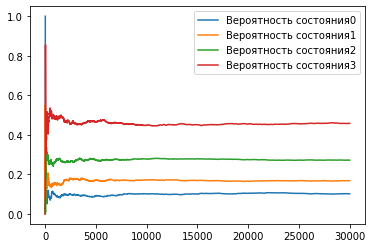

,Теор. вероятности состояний,Эмпир. вероятности состояний
0,0.099265,0.102067
1,0.165441,0.167941
2,0.275735,0.271858
3,0.459559,0.458133


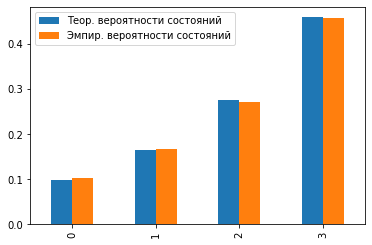

,Теор. показатели,Эмп. показатели
Абсолютная пропускная способность,0.180147,0.180622
Вероятность отказа,0.459559,0.458133
Среднее количество заявок в СМО,2.095588,2.086057
Среднее количество заявок в очереди,1.194853,1.188124
Среднее время нахождения заявки в очереди,3.584559,3.564373
Среднее количество используемых каналов,0.900735,0.897933


In [7]:
sim = Simulator(rq_intensity=1/3,
              service_shape=1,
              service_intensity=1/5)
sim.full_compare()

Далее иследуем СМО при различных значениях тех параметров, которые не зафиксированы условием задачи:

Попробуем изменить параметр распределния Эрланга (service_shape). По логике, при его увеличении должно увеличиться среднее время на обслуживание, т.к. распределение Эрланга с параметром k, характеризует время ожидания до того, как в Пуассоновском потоке событие произойдет k раз. Протестируем симуляцией:

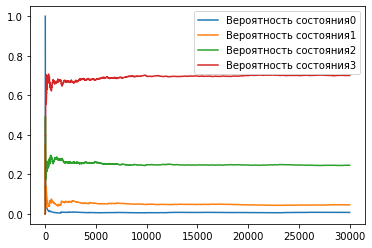

,Теор. вероятности состояний,Эмпир. вероятности состояний
0,0.007146,0.007545
1,0.043673,0.045953
2,0.247037,0.245998
3,0.702144,0.700505


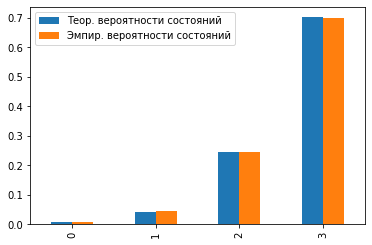

,Теор. показатели,Эмп. показатели
Абсолютная пропускная способность,0.099285,0.099832
Вероятность отказа,0.702144,0.700505
Среднее количество заявок в СМО,2.644178,2.639462
Среднее количество заявок в очереди,1.651325,1.647007
Среднее время нахождения заявки в очереди,4.953975,4.941022
Среднее количество используемых каналов,0.992854,0.992455


In [8]:
sim = Simulator(rq_intensity=1/3,
              service_shape=2,
              service_intensity=1/5)
sim.full_compare()

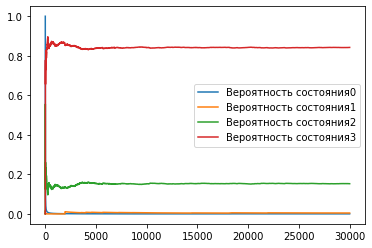

,Теор. вероятности состояний,Эмпир. вероятности состояний
0,0.000062,0.000354
1,0.003059,0.004586
2,0.146870,0.152818
3,0.850009,0.842243


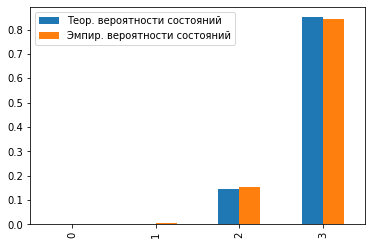

,Теор. показатели,Эмп. показатели
Абсолютная пропускная способность,0.049997,0.052586
Вероятность отказа,0.850009,0.842243
Среднее количество заявок в СМО,2.846827,2.836950
Среднее количество заявок в очереди,1.846889,1.837303
Среднее время нахождения заявки в очереди,5.540667,5.511910
Среднее количество используемых каналов,0.999938,0.999646


In [9]:
sim = Simulator(rq_intensity=1/3,
              service_shape=4,
              service_intensity=1/5)
sim.full_compare()

Как можно заметить, вероятности сдвигаются больше в правую сторону, т.е. очередь плотнее заполняется, что и потверждает нашу гипотезу. Далее попробуем увеличить второй параметр закона Эрланга, по сути интенсивность:

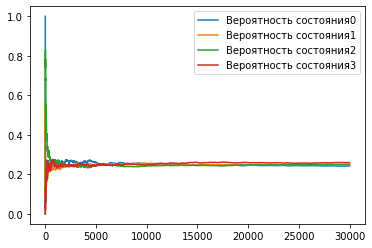

,Теор. вероятности состояний,Эмпир. вероятности состояний
0,0.25,0.242681
1,0.25,0.248071
2,0.25,0.250157
3,0.25,0.259091


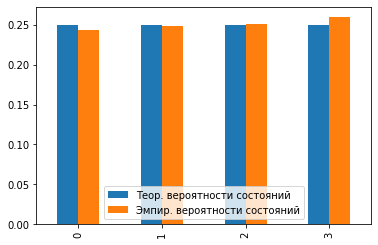

,Теор. показатели,Эмп. показатели
Абсолютная пропускная способность,0.25,0.246970
Вероятность отказа,0.25,0.259091
Среднее количество заявок в СМО,1.50,1.525659
Среднее количество заявок в очереди,0.75,0.768339
Среднее время нахождения заявки в очереди,2.25,2.305018
Среднее количество используемых каналов,0.75,0.757319


In [10]:
sim = Simulator(rq_intensity=1/3,
              service_shape=1,
              service_intensity=1/3)
sim.full_compare()

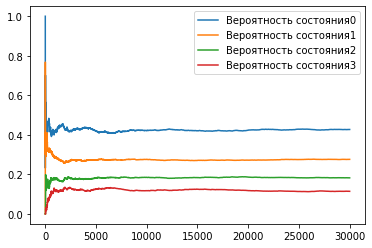

,Теор. вероятности состояний,Эмпир. вероятности состояний
0,0.415385,0.427170
1,0.276923,0.275975
2,0.184615,0.182489
3,0.123077,0.114366


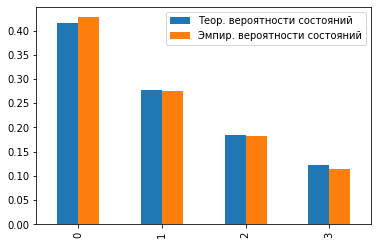

,Теор. показатели,Эмп. показатели
Абсолютная пропускная способность,0.292308,0.295211
Вероятность отказа,0.123077,0.114366
Среднее количество заявок в СМО,1.015385,0.984051
Среднее количество заявок в очереди,0.430769,0.411221
Среднее время нахождения заявки в очереди,1.292308,1.233663
Среднее количество используемых каналов,0.584615,0.572830


In [11]:
sim = Simulator(rq_intensity=1/3,
              service_shape=1,
              service_intensity=1/2)
sim.full_compare()

В данном случае, очередь становится более свободной, что логично, так как мы увеличивали интенсивность обслуживания. Далее попробуем увеличить оба параметра одновременно:

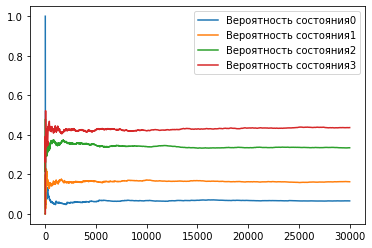

,Теор. вероятности состояний,Эмпир. вероятности состояний
0,0.067862,0.065869
1,0.160229,0.162767
2,0.331192,0.334711
3,0.440717,0.436653


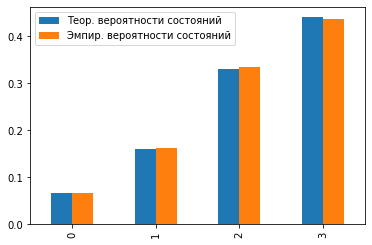

,Теор. показатели,Эмп. показатели
Абсолютная пропускная способность,0.186428,0.187782
Вероятность отказа,0.440717,0.436653
Среднее количество заявок в СМО,2.144765,2.142148
Среднее количество заявок в очереди,1.212626,1.208016
Среднее время нахождения заявки в очереди,3.637879,3.624049
Среднее количество используемых каналов,0.932138,0.934131


In [12]:
sim = Simulator(rq_intensity=1/3,
              service_shape=2,
              service_intensity=1/2.5)
sim.full_compare()

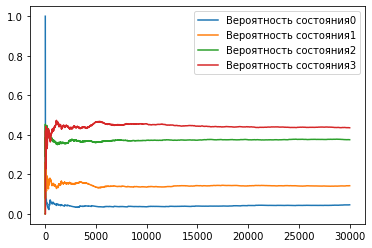

,Теор. вероятности состояний,Эмпир. вероятности состояний
0,0.049649,0.046077
1,0.150329,0.142662
2,0.370232,0.375405
3,0.429790,0.435856


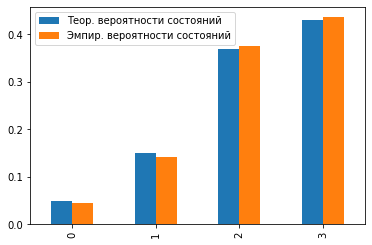

,Теор. показатели,Эмп. показатели
Абсолютная пропускная способность,0.190070,0.188048
Вероятность отказа,0.429790,0.435856
Среднее количество заявок в СМО,2.180162,2.201040
Среднее количество заявок в очереди,1.229811,1.247117
Среднее время нахождения заявки в очереди,3.689433,3.741351
Среднее количество используемых каналов,0.950351,0.953923


In [13]:
sim = Simulator(rq_intensity=1/3,
              service_shape=4,
              service_intensity=1/1.25)
sim.full_compare()

В целом, можно наблюдать, что параметры компенсируют друг друга в каком-то смысле, однако первый все-таки имеет больший эффект, так как вероятности немного сдвигаются вправо. Далее попробуем уменшить интенсивность потока заявок:

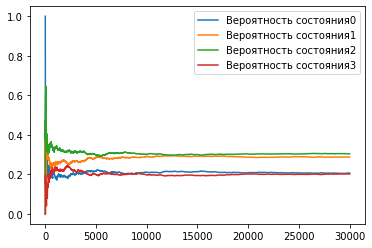

,Теор. вероятности состояний,Эмпир. вероятности состояний
0,0.199707,0.206596
1,0.287859,0.287670
2,0.312728,0.304075
3,0.199707,0.201660


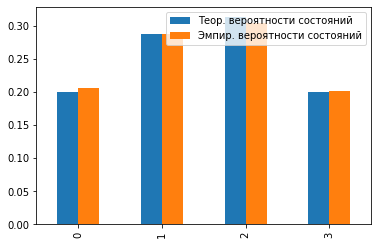

,Теор. показатели,Эмп. показатели
Абсолютная пропускная способность,0.160059,0.159668
Вероятность отказа,0.199707,0.201660
Среднее количество заявок в СМО,1.512434,1.500798
Среднее количество заявок в очереди,0.712141,0.707394
Среднее время нахождения заявки в очереди,3.560706,3.536971
Среднее количество используемых каналов,0.800293,0.793404


In [14]:
sim = Simulator(rq_intensity=1/5,
              service_shape=4,
              service_intensity=1/1.25)
sim.full_compare()

Вполне логично, система лучше справляется с обработкой